<a href="https://colab.research.google.com/github/KareemEzzaldin/CodeAlpha-Credit-Scoring-Model/blob/main/CodeAlpha_CreditScoringModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CreditScoringModel

In [40]:
!pip install catboost
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv("/content/credit_risk_dataset.csv")

In [8]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [9]:
# Remove unrealistic outliers
df = df[(df['person_age'] >= 18) & (df['person_age'] <= 100)]
df = df[(df['person_emp_length'] <= 60)]
df = df[(df['person_income'] <= 500000)]

# Handle missing values
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

In [11]:
# One-hot encoding for categorical variables
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [12]:
df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,False,True,...,False,False,False,True,False,False,False,False,False,False
2,25,9600,1.0,5500,12.87,1,0.57,3,False,False,...,True,False,False,False,True,False,False,False,False,False
3,23,65500,4.0,35000,15.23,1,0.53,2,False,False,...,True,False,False,False,True,False,False,False,False,False
4,24,54400,8.0,35000,14.27,1,0.55,4,False,False,...,True,False,False,False,True,False,False,False,False,True
5,21,9900,2.0,2500,7.14,1,0.25,2,False,True,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,30,False,False,...,False,True,False,False,True,False,False,False,False,False
32577,54,120000,4.0,17625,7.49,0,0.15,19,False,False,...,False,True,False,False,False,False,False,False,False,False
32578,65,76000,3.0,35000,10.99,1,0.46,28,False,False,...,False,False,False,True,False,False,False,False,False,False
32579,56,150000,5.0,15000,11.48,0,0.10,26,False,False,...,False,True,False,True,False,False,False,False,False,False


In [13]:
df.duplicated().sum()

np.int64(156)

In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df.isna().sum()

,0
person_age,0
person_income,0
person_emp_length,0
loan_amnt,0
loan_int_rate,0
loan_status,0
loan_percent_income,0
cb_person_cred_hist_length,0
person_home_ownership_OTHER,0
person_home_ownership_OWN,0


In [16]:
df.fillna(df.median(numeric_only=True), inplace=True)

In [17]:
df.isna().sum()

,0
person_age,0
person_income,0
person_emp_length,0
loan_amnt,0
loan_int_rate,0
loan_status,0
loan_percent_income,0
cb_person_cred_hist_length,0
person_home_ownership_OTHER,0
person_home_ownership_OWN,0


In [18]:
x = df.drop("loan_status", axis=1)
y = df["loan_status"]

<Axes: ylabel='count'>

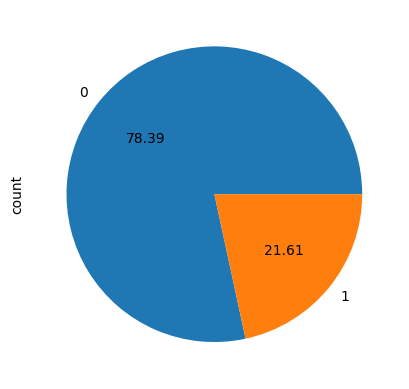

In [19]:
y.value_counts()
y.value_counts().plot.pie(autopct="%.2f")

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [22]:
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Before SMOTE: loan_status
0    19736
1     5441
Name: count, dtype: int64
After SMOTE: loan_status
1    19736
0    19736
Name: count, dtype: int64


<Axes: ylabel='count'>

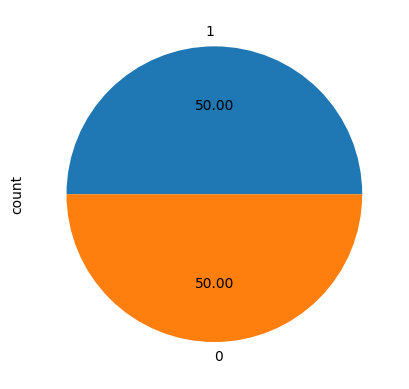

In [23]:
y_train_resampled.value_counts().plot.pie(autopct="%.2f")

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_resampled)
x_test_scaled = scaler.transform(x_test)

Cross-validated F1 scores: [0.95636364 0.95766575 0.95502542 0.95715778 0.95871858]
Mean F1 score: 0.9569862359046359
[LightGBM] [Info] Number of positive: 19736, number of negative: 19736
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1403
[LightGBM] [Info] Number of data points in the train set: 39472, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9335980937251788
Precision: 0.944392082940622
Recall: 0.7362233651726672
F1 Score: 0.8274153592072667
Confusion Matrix:
 [[4875   59]
 [ 359 1002]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      4934
           1       0.94      0.74      0.83      1361

    accuracy                           0.93      6295
   macro avg       0.94      0.86      0.89      6295
weighted avg       0.93      0.93      0.93      6295



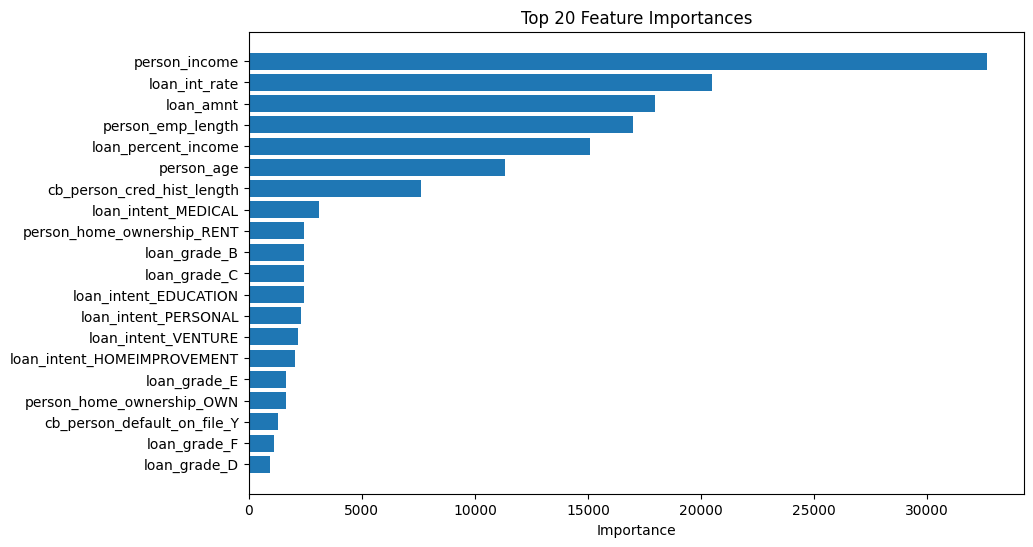

In [33]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=150,
    max_depth=-1,
    min_child_samples=30,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lgb_model, x_train_scaled, y_train_resampled, cv=cv, scoring='f1', n_jobs=-1)
print("Cross-validated F1 scores:", cv_scores)
print("Mean F1 score:", np.mean(cv_scores))

lgb_model.fit(x_train_scaled, y_train_resampled)
y_pred = lgb_model.predict(x_test_scaled)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


importances = lgb_model.feature_importances_
features = x.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances")
plt.show()